# HW 1 Problem 2

## Setup Kaggle Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dennisloevlie","key":"cbe54b3c2f523675dbd2d958419139df"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
shivan118/healthcare-analytics                         AV : Healthcare Analytics                           2MB  2020-09-13 17:40:05           2023  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification        4MB  2020-09-08 11:40:11           1350  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           2418  
Cornell-University/arxiv                               arXiv Dataset                                     888MB  2020-09-22 15:33:49           3105  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND ETHNICITY (FACE DATA) CSV          

In [ ]:
! kaggle competitions download -c '11-785-fall-20-homework-1-part-2'

 98% 96.0M/98.1M [00:01<00:00, 39.6MB/s]
100% 98.1M/98.1M [00:01<00:00, 59.9MB/s]
 99% 1.56G/1.57G [00:25<00:00, 32.8MB/s]
100% 1.57G/1.57G [00:25<00:00, 65.9MB/s]
 79% 78.0M/98.6M [00:00<00:00, 56.8MB/s]
100% 98.6M/98.6M [00:00<00:00, 119MB/s] 
  0% 0.00/9.45M [00:00<?, ?B/s]
100% 9.45M/9.45M [00:00<00:00, 86.9MB/s]
  0% 0.00/622k [00:00<?, ?B/s]
100% 622k/622k [00:00<00:00, 205MB/s]
  0% 0.00/3.36M [00:00<?, ?B/s]
100% 3.36M/3.36M [00:00<00:00, 230MB/s]
  0% 0.00/3.19k [00:00<?, ?B/s]
100% 3.19k/3.19k [00:00<00:00, 3.12MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip train.npy.zip -d train

Archive:  train.npy.zip
  inflating: train/train.npy         


In [ ]:
! unzip train_labels.npy.zip -d train

Archive:  train_labels.npy.zip
  inflating: train/train_labels.npy  


In [ ]:
! unzip test.npy.zip -d test

Archive:  test.npy.zip
  inflating: test/test.npy           


In [ ]:
! unzip dev.npy.zip -d val

Archive:  dev.npy.zip
  inflating: val/dev.npy             


In [ ]:
! unzip dev_labels.npy.zip -d val

Archive:  dev_labels.npy.zip
  inflating: val/dev_labels.npy      


In [ ]:
! unzip sample.csv.zip -d sample

Archive:  sample.csv.zip
  inflating: sample/sample.csv       


In [ ]:
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions        Commands related to Kaggle competitions
    datasets            Commands related to Kaggle datasets
    kernels             Commands related to Kaggle kernels
    config              Configuration settings


## Loading all the Data

Imports 

In [ ]:
import numpy as np

Loading the data

* **train.npy - training features**
* [train|dev|test].npy contain a numpy object array of shape [utterances]. Each utterance is a float32 ndarray of shape [time, frequency], where time is the length of the utterance. Frequency dimension is always 13 but time dimension is of variable length.

In [ ]:
Train_data = np.load('train/train.npy',allow_pickle=True,fix_imports=True)

In [ ]:
x = np.concatenate(Train_data)

* **training labels dev.npy - development/validation features**
* [train|dev]_labels.npy contain a numpy object array of shape [utterances]. Each element in the array is an int32 array of shape [time] and provides the phoneme state label for each frame. There are 346 distinct labels [0-345], one for each subphoneme.

In [ ]:
Train_labels = np.load('train/train_labels.npy',allow_pickle=True)

In [ ]:
y = np.concatenate(Train_labels)

* **dev.npy - development/validation features**
* **dev_labels.npy - development/validation**

In [ ]:
Val_data = np.load('val/dev.npy',allow_pickle=True)

In [ ]:
Val_labels = np.load('val/dev_labels.npy',allow_pickle=True)

**Test Data**

In [ ]:
Test_data = np.load('test/test.npy',allow_pickle=True)

**sample.csv - sample submission in correct format**

In [ ]:
import pandas as pd
sample = pd.read_csv('sample/sample.csv')

In [ ]:
y_test = sample['label'].to_numpy()

## Setting up the Model

In [ ]:
!pip install torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
k = 20 # context size for utterance of size (A,13) a k of 5 makes the utterance (A + 2*5, 13)

In [ ]:
class Model(nn.Module):

    def __init__(self,in_features=13*(1 + 2*k),h1=2048,h2=2048,h3=1024*2,h4=1024,h5=900,h6=900,h7=800,
                 h8=800,h9 = 800,h10=800,h11=800,h12=800,h13=800,h14=800,h15=800,out_features=346):
        
        # How many layers?
        # Input layer (# of features) --> hidden layer 1 (number of neurons N) --> h2 (N) --> output (346 of classes)
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.bn1 = nn.BatchNorm1d(num_features=h1,momentum=0.01)
        self.fc2 = nn.Linear(h1,h2)
        self.d2 =  nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(num_features=h2,momentum=0.01)
        self.fc3 = nn.Linear(h2,h3)
        self.bn3 = nn.BatchNorm1d(num_features=h3,momentum=0.01)
        self.d3 = nn.Dropout(0.4)
        self.fc4 = nn.Linear(h3,h4)
        self.bn4 = nn.BatchNorm1d(num_features=h4,momentum=0.01)
        self.d4 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(h4,h5)
        self.bn5 = nn.BatchNorm1d(num_features=h5,momentum=0.01)
        self.d5 = nn.Dropout(0.25)
        self.fc6 = nn.Linear(h5,h6)
        self.bn6 = nn.BatchNorm1d(num_features=h6,momentum=0.01)
        self.d6 = nn.Dropout(0.35)
        
        self.fc7 = nn.Linear(h6,h7)
        self.bn7 = nn.BatchNorm1d(num_features=h7,momentum=0.01)
        self.d7 = nn.Dropout(0.4)
        
        self.fc8 = nn.Linear(h7,h8)
        self.bn8 = nn.BatchNorm1d(num_features=h8,momentum=0.01)
        self.d8 = nn.Dropout(0.35)
        
        self.fc9 = nn.Linear(h8,h9)
        self.bn9 = nn.BatchNorm1d(num_features=h9,momentum=0.01)
        self.d9 = nn.Dropout(0.2)
        
        self.fc10 = nn.Linear(h9,h10)
        self.bn10 = nn.BatchNorm1d(num_features=h10,momentum=0.01)
        self.d10 = nn.Dropout(0.25)
        
        self.fc11 = nn.Linear(h10,h11)
        self.bn11 = nn.BatchNorm1d(num_features=h11,momentum=0.01)
        self.d11 = nn.Dropout(0.2)

        self.fc12 = nn.Linear(h11,h12)
        self.bn12 = nn.BatchNorm1d(num_features=h12,momentum=0.01)
        self.d12 = nn.Dropout(0.2)

        self.fc13 = nn.Linear(h12,h13)
        self.bn13 = nn.BatchNorm1d(num_features=h13,momentum=0.01)
        self.d13 = nn.Dropout(0.2)

        self.fc14 = nn.Linear(h13,h14)
        self.bn14 = nn.BatchNorm1d(num_features=h14,momentum=0.01)
        self.d14 = nn.Dropout(0.2)

        self.fc15 = nn.Linear(h14,h15)
        self.bn15 = nn.BatchNorm1d(num_features=h15,momentum=0.01)
        self.d15 = nn.Dropout(0.2)

        self.out = nn.Linear(h15,out_features)
  
    def forward(self,x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.d2(self.fc2(x))))
        x = F.relu(self.bn3(self.d3(self.fc3(x))))
        x = F.relu(self.bn4(self.d4(self.fc4(x))))
        x = F.relu(self.bn5(self.d5(self.fc5(x))))
        x = F.relu(self.bn6(self.d6(self.fc6(x))))
        x = F.relu(self.bn7(self.d7(self.fc7(x))))
        x = F.relu(self.bn8(self.d8(self.fc8(x))))
        x = F.relu(self.bn9(self.d9(self.fc9(x))))
        x = F.relu(self.bn10(self.d10(self.fc10(x))))
        x = F.relu(self.bn11(self.d11(self.fc11(x))))
        x = F.relu(self.bn12(self.d12(self.fc12(x))))
        x = F.relu(self.bn13(self.d13(self.fc13(x))))
        x = F.relu(self.bn14(self.d14(self.fc14(x))))
        x = F.relu(self.bn15(self.d15(self.fc15(x))))

        x = self.out(x)
        return x

In [ ]:
seq_model = Model()

## Working with Tensors 

In [ ]:
!pip install torchvision

In [ ]:
from __future__ import print_function, division
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
class My_Dataset(Dataset):
    
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        if index > len(self.X) - (k + 1):
            X = torch.Tensor(np.pad(self.X[index-k-1:].float(),pad_width=((0,(k  - len(self.X[index:].float()))),(0,0)),mode='reflect').flatten())
        elif index <  k + 1:
            X = torch.Tensor(np.pad(self.X[:index+k+1].float(),pad_width=((k  - index,0),(0,0)),mode='reflect').flatten())
        else:
            X = self.X[index-k:index+k+1].float().flatten()
            
        Y = self.Y[index].long()
        return X,Y

In [ ]:
X_test = torch.Tensor(np.concatenate(Test_data))
y_test = torch.Tensor(y_test)

In [ ]:
y_val = torch.Tensor(np.concatenate(Val_labels))
x_val = torch.Tensor(np.concatenate(Val_data))

In [ ]:
x = torch.Tensor(x)
y = torch.Tensor(y)

In [ ]:
val_dataset = My_Dataset(x_val,y_val)

In [ ]:
val_loader_args = dict(shuffle=False,batch_size=1024,num_workers=6,pin_memory=True)
val_loader = DataLoader(val_dataset, **val_loader_args)

In [ ]:
test_dataset = My_Dataset(X_test,y_test)

In [ ]:
test_loader_args = dict(shuffle=False,batch_size=1024,num_workers=6,pin_memory=True) 
test_loader = DataLoader(test_dataset, **test_loader_args)

In [ ]:
train_dataset = My_Dataset(x,y)

In [ ]:
train_loader_args = dict(shuffle=True,batch_size=1024,num_workers=6,pin_memory=True,drop_last=True) 
train_loader = DataLoader(train_dataset, **train_loader_args)

# Training the Model

In [ ]:
device = torch.device("cuda")
seq_model.to(device)

Model(
  (fc1): Linear(in_features=585, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=2700, out_features=2700, bias=Tr

In [ ]:
seq_model.train()

Model(
  (fc1): Linear(in_features=585, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=2700, out_features=2700, bias=Tr

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(seq_model.parameters(),lr=1e-4)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=33)

In [ ]:
seq_model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=585, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_featur

In [ ]:
def validation_error(model,criterion,val_loader):
    model.eval()
    loss = []
    for (xii,yii) in val_loader:
        output = model.forward(xii)
        loss = criterion(output,yii.cuda())
    #val_error = np.mean(np.array(loss))
    val_error = loss
    return val_error

In [ ]:
def Testing_Model(seq_model,test_loader,epoch):
  import numpy as np 
  import torch 
  import pandas as pd
  torch.save(seq_model.state_dict(), f'MyModel_{epoch}.pt')
  model2 = Model()
  model2.load_state_dict(torch.load(f'MyModel_{epoch}.pt'));
  device = torch.device("cuda")
  model2.to(device)
  model2.eval()
  test_preds = []
  for (xj,yj) in test_loader:
      output = model2.forward(xj)
      test_preds.append(np.argmax(output.cpu().detach().numpy(),axis=1))
  combined_batches = np.array(test_preds)
  Predictions = np.concatenate(combined_batches)
  id = [i for i in range(len(Predictions))]
  df_pred = pd.DataFrame(data={'id':id,'label':Predictions})
  df_pred.to_csv(f'Predictions.csv',index=False)
  !kaggle competitions submit -c 11-785-fall-20-homework-1-part-2 -f Predictions.csv -m "Submission"

In [ ]:
%%time
# EPOCHS 
seq_model.train()
epochs = 25
losses = []
loss = []
val_error = []
validation_losses = []
for i in range(epochs):
    losses.append(loss)
    validation_losses.append(val_error)
    seq_model.train()
    print(f'Epoch {i}, loss {loss}, validation loss: {val_error}')
    for (xi,yi) in train_loader:
        optimizer.zero_grad()
        xi = xi.to(device)
        yi = yi.to(device)
        output = seq_model(xi)
        loss = criterion(output,yi)
        loss.backward()
        optimizer.step()

    if (i+1) % 5 == 0:
      Testing_Model(seq_model,test_loader,i)
    val_error = validation_error(seq_model,criterion,val_loader)

In [ ]:
torch.save(seq_model.state_dict(), 'MyModel_V6.pt')

# Predicting on the Test data 

In [ ]:
import numpy as np 
import torch 
import pandas as pd
model2 = Model()
model2.load_state_dict(torch.load(f'MyModel_V11.pt'));
model2.eval()

Model(
  (fc1): Linear(in_features=1001, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=2700, out_features=2700, bias=T

In [ ]:
device = torch.device("cuda")
model2.to(device)

Model(
  (fc1): Linear(in_features=1001, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (d2): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=2048, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=2700, bias=True)
  (bn5): BatchNorm1d(2700, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (d5): Dropout(p=0.25, inplace=False)
  (fc6): Linear(in_features=2700, out_features=2700, bias=T

In [ ]:
model2.eval()
test_preds = []
print('Hello')
for (xj,yj) in test_loader:
    output = model2.forward(xj)
    test_preds.append(np.argmax(output.cpu().detach().numpy(),axis=1))

Hello


In [ ]:
np.concatenate(np.array(test_preds)).shape

(1593223,)

In [ ]:
combined_batches = np.array(test_preds)
combined_batches.shape

(1556,)

In [ ]:
Predictions = np.concatenate(combined_batches)
Predictions.shape

(1593223,)

In [ ]:
id = [i for i in range(len(Predictions))]

In [ ]:
df_pred = pd.DataFrame(data={'id':id,'label':Predictions})
df_pred

,id,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
1593218,1593218,1
1593219,1593219,1
1593220,1593220,1
1593221,1593221,1


In [ ]:
df_pred.to_csv(f'Predictions.csv',index=False)

In [ ]:
!kaggle competitions submit -c 11-785-fall-20-homework-1-part-2 -f Predictions.csv -m "Submission"

# Evaluating Training losses 

In [ ]:
losses = losses[1:]

Text(0, 0.5, 'CrossEntropyLoss')

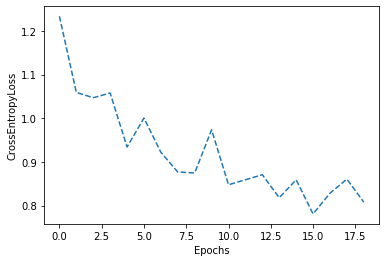

In [ ]:
import seaborn as sns
#sns.set_style('DarkGrid')
plt.plot(losses,'--')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')